# Lie Detection: Reliability of Relevant Predictors in Classifiers

[INTRODUCTION OF THE PROBLEM HERE]

### Datasets:
[ADD AND COMMENT ABOUT DATASETS HERE]
### Tasks:
[ADD TASK HERE]

### Integrants:
Name, Matricola, Email respectively
- Santiago Víquez Segura, 2048722, santiago.viquezsegura@studenti.unipd.it
- Phillippe Robert, 2041505, philippe.robert@studenti.unipd.it
- Huzaifa Fazal,

## Summary

The project aims at examining the reliability of predictors in classifiers used in the field of behavioral science. More specifically, the project’s goal is to determine the effectiveness and the replicability of various predictors in accurately identifying or grouping individuals based on their behavior on psychometrics tests. Realizing this goal would improve the consistency and accuracy of classifiers, which will have a beneficial effects on fields such as psychology.

To accomplish this, we will conduct the following test.  N.B. We decided to use the F1-score metric instead of the accuracy due to imbalance in the datasets. 

* We will examine if different Machine Learning models with comparable F1-scores exhibit variations in their most important features selected, and this for all datasets. 

* We will analyze 20% of the items to determine the F1-score and its deviation from the original test. Furthermore, we will examine the concordance among classifiers in identifying the 20% best items.

* Do model-agnostic feature selection methods surpass model-dependent ones

* Investigate whether items selection inspired by psychometric methods outperforms model-based item selection.

## Dependencies: importing the necessary lobrairies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_validate
from sklearn.ensemble import  RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold
from xgboost import XGBClassifier
from sklearn import svm
import shap
# figure size in inches
plt.rcParams['figure.figsize'] = 11.7,8.27


#Import library needed to perferm the autoencoder features extration.
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot
import tensorflow as tf

# Load datasets

### Loading the 13 different datasets as DataFrame 

In [24]:
BF_CTU_df = pd.read_csv("data/BF_df_CTU.csv", delimiter=",")
BF_OU_df = pd.read_csv("data/BF_df_OU.csv", delimiter=",")
BF_V_df = pd.read_csv("data/BF_df_V.csv", delimiter=",")
DT_CC_df = pd.read_csv("data/DT_df_CC.csv", delimiter=",")
DT_JI_df = pd.read_csv("data/DT_df_JI.csv", delimiter=";")
IADQ_df = pd.read_csv("data/IADQ_df.csv", delimiter=",")
IESR_df = pd.read_csv("data/IESR_df.csv", delimiter=",")
NAQR_df = pd.read_csv("data/NAQ_R_df.csv", delimiter=";")
PCL5_df = pd.read_csv("data/PCL5_df.csv", delimiter=";").dropna(subset=["CONDITION"])
PHQ9_df = pd.read_csv("data/PHQ9_GAD7_df.csv", delimiter=";")
PID5_df = pd.read_csv("data/PID5_df.csv", delimiter=";").dropna(subset=["CONDITION"])
PRFQ_df = pd.read_csv("data/PRFQ_df.csv", delimiter=",")
PRMQ_df = pd.read_csv("data/PRMQ_df.csv", delimiter=",")
DDDT_df = pd.read_csv("data/RAW_DDDT.CSV", delimiter=",")
SPID5_df = pd.read_csv("data/sPID-5_df.csv", delimiter=",")

RNEOPI_honest_df = pd.read_excel("data/Honest.xlsx", header=1)
RNEOPI_fake_df = pd.read_excel("data/Faked.xlsx", header=1)
RNEOPI_honest_df["CONDITION"] = "H"
RNEOPI_fake_df["CONDITION"] = "D"
RNEOPI_df = pd.concat([RNEOPI_honest_df, RNEOPI_fake_df])

Fill missing values with the token "-999"

In [25]:
BF_CTU_df = BF_CTU_df.fillna("-999")
BF_OU_df = BF_OU_df.fillna("-999")
BF_V_df = BF_V_df.fillna("-999")
DT_CC_df = DT_CC_df.fillna("-999")
DT_JI_df = DT_JI_df.fillna("-999")
IADQ_df = IADQ_df.fillna("-999")
IESR_df = IESR_df.fillna("-999")
NAQR_df = NAQR_df.fillna("-999")
PCL5_df = PCL5_df.fillna("-999")
PHQ9_df = PHQ9_df.fillna("-999")
PID5_df = PID5_df.fillna("-999")
PRFQ_df = PRFQ_df.fillna("-999")
PRMQ_df = PRMQ_df.fillna("-999")
DDDT_df = DDDT_df.fillna("-999")
SPID5_df = SPID5_df.fillna("-999")
RNEOPI_df = RNEOPI_df.fillna("-999")

## Helper Functions

In [12]:
def evaluate_clf(df, clf, cv):
    """
    Performs cross-validation of a classifier over a dataset
    
    Args:
        df: (pd.DataFrame) train dataset
        clf: (sklearn fitted estimator)
        cv: (int) number of folds
        
    Returns:
        output: (dict) {fit_time:[...], score_time:[...], estimator:[...], test_score:[...]}
    """
    X = df.loc[:, df.columns != 'CONDITION'] # select all columns except CONDITION
    y = np.where(df["CONDITION"] == "H", 1, 0)
    output = cross_validate(clf, X, y, cv=cv, scoring='f1', return_estimator=True)
    
    return output

In [13]:
def get_feature_importance(model_output):
    """
    Averages feature importances / coefficient values from all the fitted estimators
    
    Args:
        model_output: (list) sklearn fitted estimators
    
    Retruns: (dict) {predictor: value}
    """
    
    n_folds = len(output["estimator"])
    coeficients = 0
    
    for estimator in output["estimator"]:
        if isinstance(estimator, LogisticRegression) or isinstance(estimator, svm.SVC):
            coeficients += estimator.coef_[0] # TODO: RF uses feature_importances insted of coef_
        else:
            coeficients += estimator.feature_importances_
    coeficients = np.abs(coeficients/n_folds)
    res = dict(zip(estimator.feature_names_in_, coeficients))

    return res

In [14]:
def plot_feature_importance(feature_importance, title):
    """
    Plots a bar chart of the importance/coefficients of the predictors
    
    Args:
        feature_importance: (dict) dictionary with key:feature name and value:importance
        title: (str) title of the chart
    """
    
    plt.bar(x=feature_importance.keys(), height=feature_importance.values())
    plt.title(title)
    plt.xlabel("Feature Name")
    plt.ylabel("Abs(Importance Score)")
    plt.show()

In [15]:
def get_shap_values(clf, df, cv):
    """
    Performs cross-validation of a classifier over a dataset
    and computes the shap-values for each fold.
    
    Args:
        df: (pd.DataFrame) train dataset
        clf: (sklearn fitted estimator)
        cv: (int) number of folds
        
    Returns:
        output: (tuple) shap_values: (shap.Explainer), f1_score: float
    """
    
    X = df.loc[:, df.columns != 'CONDITION'] # select all columns except CONDITION
    y = np.where(df["CONDITION"] == "H", 1, 0)

    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    list_shap_values = list()
    f1_scores = list()
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]

        #training model
        clf.fit(X_train, y_train)
        preds = clf.predict(X_test)
        f1_scores.append(f1_score(y_test, preds))

        #explaining model
        explainer = shap.Explainer(clf, X_train)
        if isinstance(clf, RandomForestClassifier):
            shap_values = explainer(X_test, check_additivity=False)
        else:
            shap_values = explainer(X_test)

        #for each iteration we save the test_set index and the shap_values
        list_shap_values.append(shap_values)
        
    # combining results from all iterations
    shap_values = np.array(list_shap_values[0].values)
    for i in range(1, cv):
        shap_values = np.concatenate((shap_values, np.array(list_shap_values[i].values)), axis=0)
    shap_values = shap.Explanation(shap_values, feature_names=X_train.columns)
    
    return shap_values, np.mean(f1_scores)

## Baseline Feature Importance - Shap Values

### Why Shap Values?

<AxesSubplot:xlabel='variable', ylabel='value'>

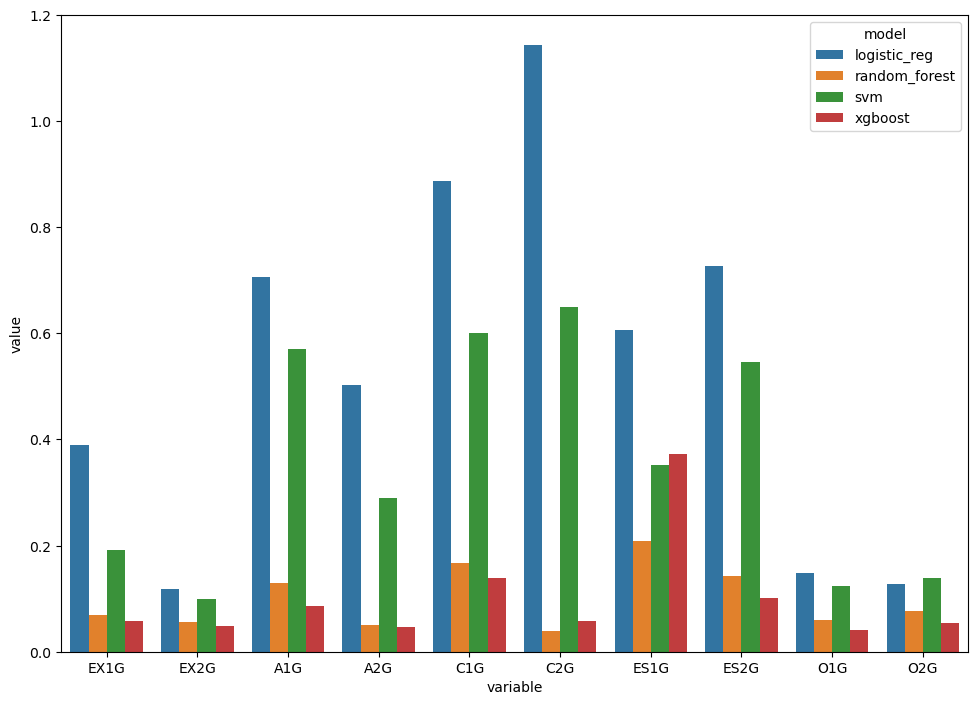

In [19]:
clf = LogisticRegression(solver="lbfgs", penalty=None)
output = evaluate_clf(BF_CTU_df, clf, cv=5)
feature_importance_lr = get_feature_importance(output)

clf = RandomForestClassifier(n_estimators=300, random_state=42)
output = evaluate_clf(BF_CTU_df, clf, cv=5)
feature_importance_rf = get_feature_importance(output)

clf = svm.SVC(kernel="linear")
output = evaluate_clf(BF_CTU_df, clf, cv=5)
feature_importance_svm = get_feature_importance(output)

clf = XGBClassifier(random_state=42)
output = evaluate_clf(BF_CTU_df, clf, cv=5)
feature_importance_xgboost = get_feature_importance(output)

feature_importance_lr['model'] ="logistic_reg"
feature_importance_rf['model'] ="random_forest"
feature_importance_svm['model'] ="svm"
feature_importance_xgboost['model'] ="xgboost"

comparison_df = pd.DataFrame.from_dict([feature_importance_lr, 
                        feature_importance_rf, 
                        feature_importance_svm,
                        feature_importance_xgboost])

comparison_df = comparison_df.melt(id_vars=["model"])

sns.barplot(data=comparison_df, x="variable", y="value", hue="model")

### Logistic Regression

Cross-Validated F1-Score: 0.8098047607227533


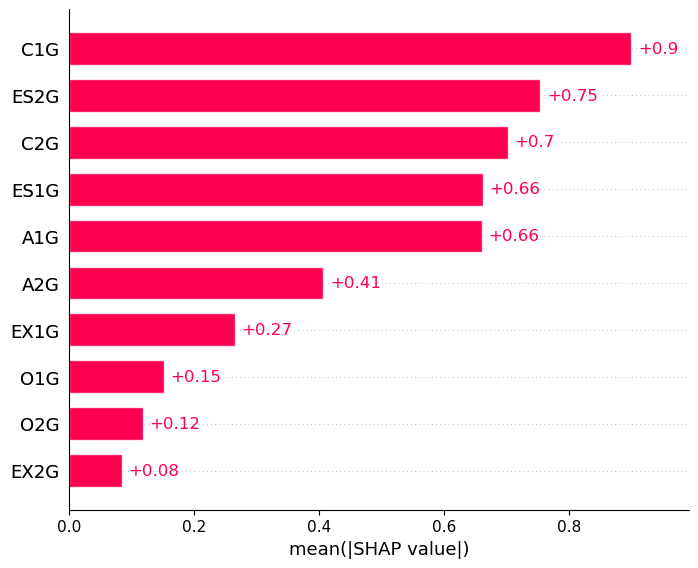

In [8]:
clf = LogisticRegression(solver="lbfgs", penalty=None)
shap_values_lr, f1 = get_shap_values(clf, BF_CTU_df, 5)
print(f"Cross-Validated F1-Score: {f1}")
shap.plots.bar(shap_values_lr)

### Random Forest

Cross-Validated F1-Score: 0.8264135923136632


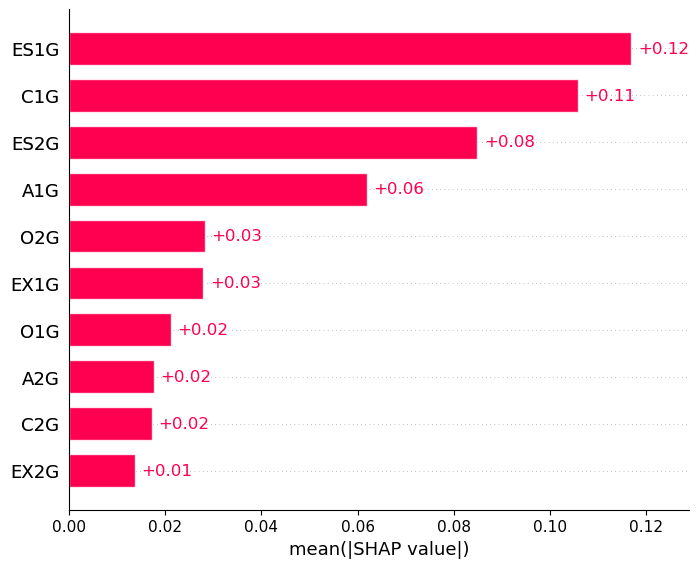

In [9]:
clf = RandomForestClassifier(random_state=42)
shap_values_rf, f1 = get_shap_values(clf, BF_CTU_df, 5)
print(f"Cross-Validated F1-Score: {f1}")
shap.plots.bar(shap_values_rf[:,:,1])

### SVM

Cross-Validated F1-Score: 0.8193417996883913


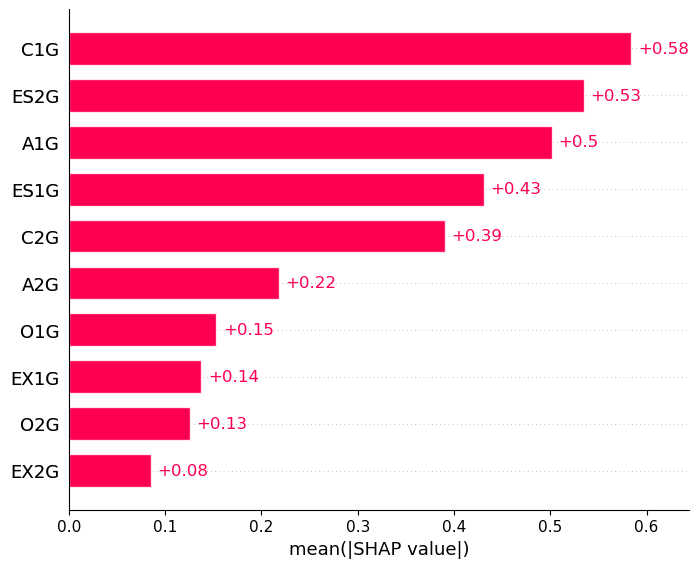

In [10]:
clf = svm.SVC(kernel="linear")
shap_values_svm, f1 = get_shap_values(clf, BF_CTU_df, 5)
print(f"Cross-Validated F1-Score: {f1}")
shap.plots.bar(shap_values_svm)

### XGBoost

Cross-Validated F1-Score: 0.8115609110462632


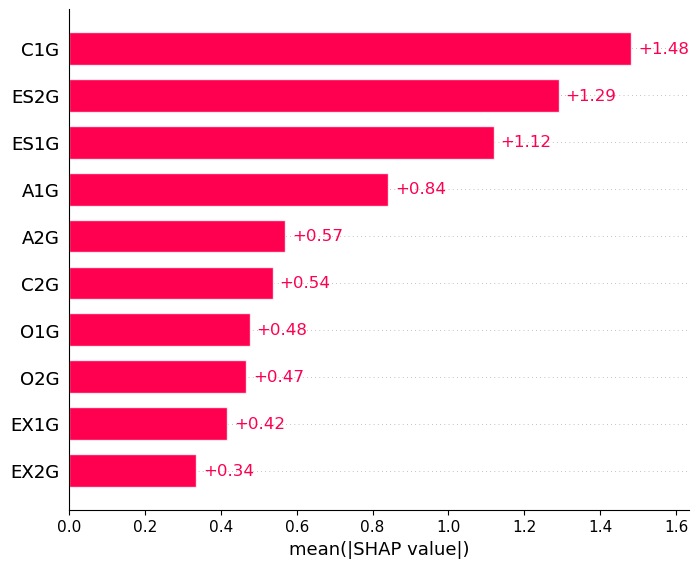

In [11]:
clf = XGBClassifier(random_state=42)
shap_values_xgboost, f1 = get_shap_values(clf, BF_CTU_df, 5)
print(f"Cross-Validated F1-Score: {f1}")
shap.plots.bar(shap_values_xgboost)

### Comparison Between Models

In [16]:
def compute_relative_shap_values(shap_values, col_names):    
    mean_shap_values = np.mean(np.abs(shap_values.values), axis=0)
    relative_shap_values = mean_shap_values / np.sum(mean_shap_values)
    relative_shap_values = dict(zip(col_names, relative_shap_values))
    return relative_shap_values

In [17]:
def compare_clfs(df, 
                 df_name:None,
                 cv=5, 
                 lr_penalty=None, 
                 lr_C=1.0, 
                 svm_penalty=None,
                 svm_C=1.0, 
                 reg_alpha=0.0,
                 plot_comparison=True,
                 return_df=False,
                 return_performance_df=None,
                 plot_name=None,
                 path=None):
    
    if lr_penalty != None:
        solver = "liblinear"
    else:
        solver = "lbfgs"

    lr = LogisticRegression(solver=solver, penalty=lr_penalty, C=lr_C)
    shap_values_lr, f1_lr = get_shap_values(lr, df, cv)
    print(f"Cross-Validated F1-Score - Logistic Regression: {f1_lr}")
    
    rf = RandomForestClassifier(random_state=42)
    shap_values_rf, f1_rf = get_shap_values(rf, df, cv)
    print(f"Cross-Validated F1-Score - Random Forest: {f1_rf}")
    
    if svm_penalty == None:
        svm_c = svm.SVC(kernel="linear")
        shap_values_svm, f1_svm = get_shap_values(svm_c, df, cv)
        print(f"Cross-Validated F1-Score - SVM: {f1_svm}")
    else:
        svm_c = svm.LinearSVC(penalty=svm_penalty, C=svm_C, dual=False)
        shap_values_svm, f1_svm = get_shap_values(svm_c, df, cv)
        print(f"Cross-Validated F1-Score - SVM: {f1_svm}")
        
    xgboost = XGBClassifier(random_state=42, reg_alpha=reg_alpha)
    shap_values_xgboost, f1_xgboost = get_shap_values(xgboost, df, cv)
    print(f"Cross-Validated F1-Score - XGBoost: {f1_xgboost}")
    

    rel_shap_values_lr = compute_relative_shap_values(shap_values_lr, df.columns)
    rel_shap_values_rf = compute_relative_shap_values(shap_values_rf[:,:,1], df.columns)
    rel_shap_values_svm = compute_relative_shap_values(shap_values_svm, df.columns)
    rel_shap_values_xgboost = compute_relative_shap_values(shap_values_xgboost, df.columns)

    rel_shap_values_lr['model'] ="logistic_reg"
    rel_shap_values_rf['model'] ="random_forest"
    rel_shap_values_svm['model'] ="svm"
    rel_shap_values_xgboost['model'] ="xgboost"

    comparison_df = pd.DataFrame.from_dict([rel_shap_values_lr, 
                            rel_shap_values_rf, 
                            rel_shap_values_svm,
                            rel_shap_values_xgboost])

    comparison_df = comparison_df.melt(id_vars=["model"])

    if svm_penalty != None:
        comparison_df = comparison_df[comparison_df.model != "random_forest"]

    if plot_comparison:
        ax = sns.barplot(data=comparison_df, x="variable", y="value", hue="model")
        ax.set_title(f'Shap Value Comparison - Data Set: {df_name}')
        ax.set_ylabel('Relative Shap Value Contribution')
        ax.set_xlabel('Feature')
        plt.xticks(rotation=45)
        if plot_name:
            plt.savefig(f'{path}/{plot_name}.png', bbox_inches='tight')
        plt.show()
    
    if return_performance_df:
        performance_df = pd.DataFrame({"Dataset": [df_name, df_name, df_name, df_name],
                                       "Model": ["lr", "rf", "svm", "xgboost"],
                                       "F1": [np.round(f1_lr, 2), 
                                              np.round(f1_rf, 2), 
                                              np.round(f1_svm, 2), 
                                              np.round(f1_xgboost, 2)]})
        return performance_df
    
    if return_df:
        return comparison_df

Cross-Validated F1-Score - Logistic Regression: 0.8098047607227533
Cross-Validated F1-Score - Random Forest: 0.8264135923136632
Cross-Validated F1-Score - SVM: 0.8193417996883913
Cross-Validated F1-Score - XGBoost: 0.8115609110462632


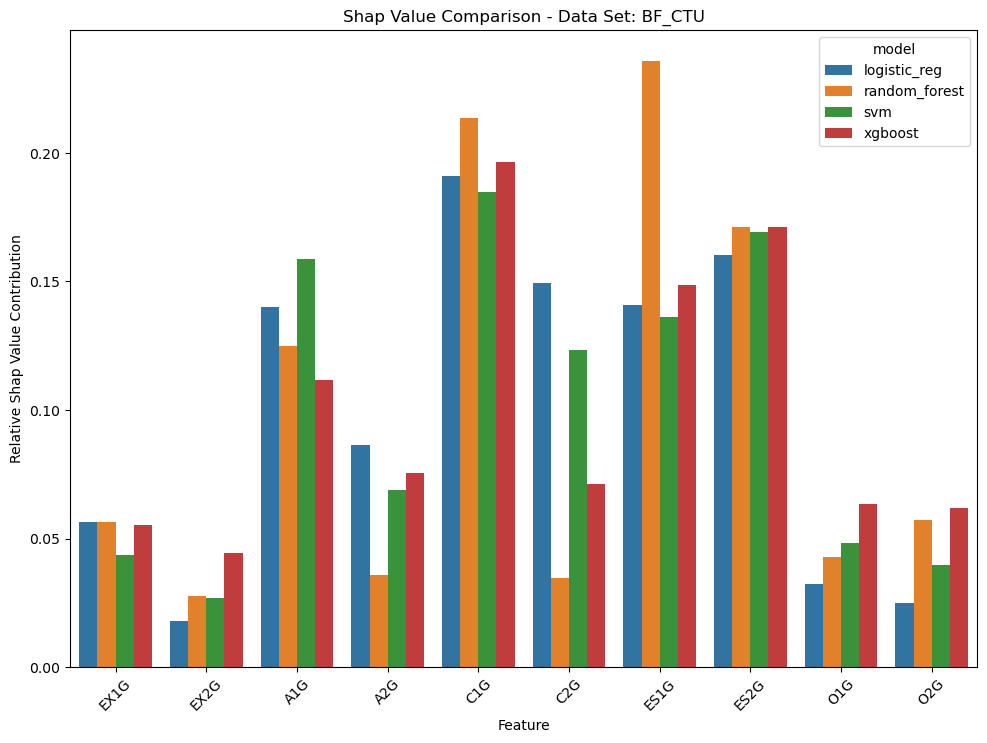

In [55]:
compare_clfs(BF_CTU_df, df_name="BF_CTU")

## Feature Selection Methods

### PCA

In [18]:
def perform_pca(df, ratio):
    n_components = int(np.round(ratio * (len(df.columns) - 1)))
    X = df.loc[:, df.columns != 'CONDITION']
    X_std = StandardScaler().fit_transform(X)    
    
    X_pca = pd.DataFrame(PCA(n_components=n_components, random_state=42).fit_transform(feature_values_std))
    X_pca.columns = [f"c_{i}" for i in range(n_components)]
    X_pca = pd.concat([X_pca, df.CONDITION], axis = 1)
    return X_pca

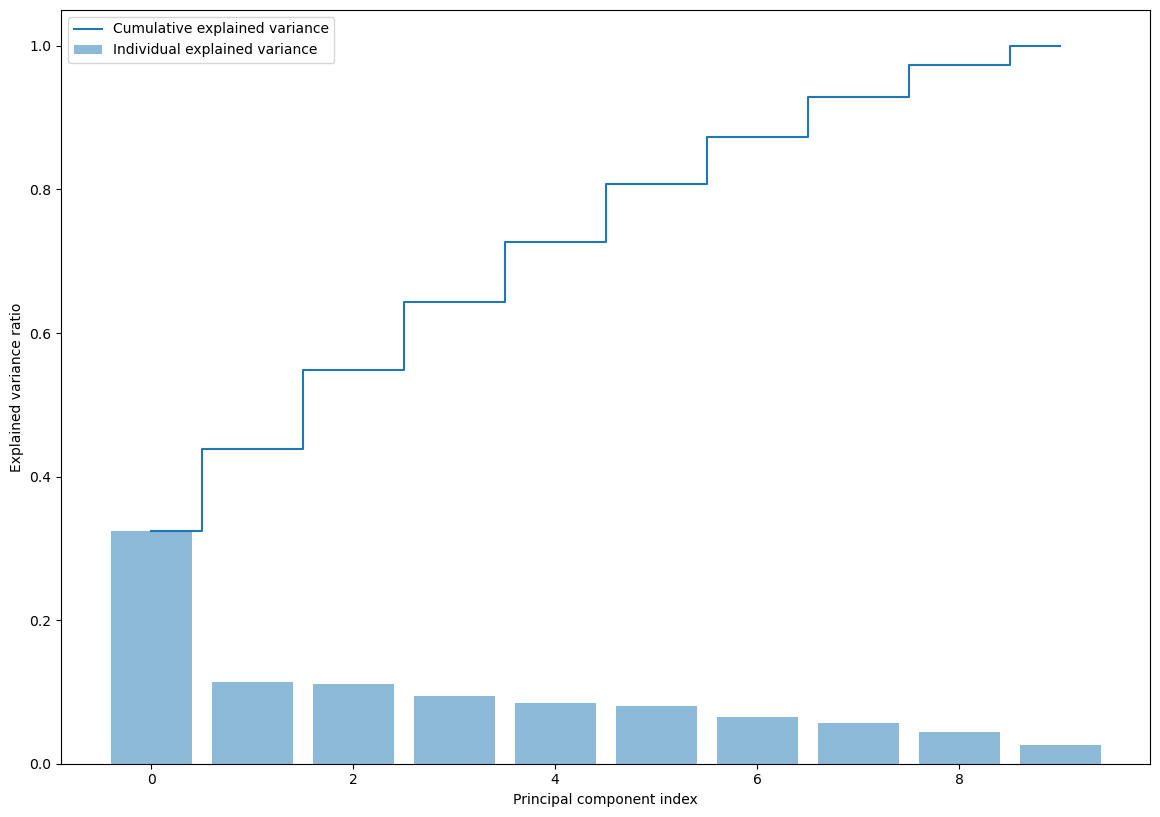

In [16]:
features  = BF_CTU_df.columns.drop("CONDITION")
feature_values = BF_CTU_df.loc[:, features].values #separating the features
feature_values_std = StandardScaler().fit_transform(feature_values)

#Finding explained variance for PCA
pca = PCA()
feature_values_pca = pca.fit_transform(feature_values_std) #Determine transformed feature
exp_var_pca = pca.explained_variance_ratio_ #Determine explained variance using explained_variance_ration_ attribute

cum_sum_eigenvalues = np.cumsum(exp_var_pca) #Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.

plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

#We can see that the first 6 components captures 80% of the total variance. Thus, I will try PCA with 6 components. 

Cross-Validated F1-Score - Logistic Regression: 0.8166888037619323
Cross-Validated F1-Score - Random Forest: 0.8248340779352914
Cross-Validated F1-Score - SVM: 0.8174075224762861
Cross-Validated F1-Score - XGBoost: 0.7986955660609631


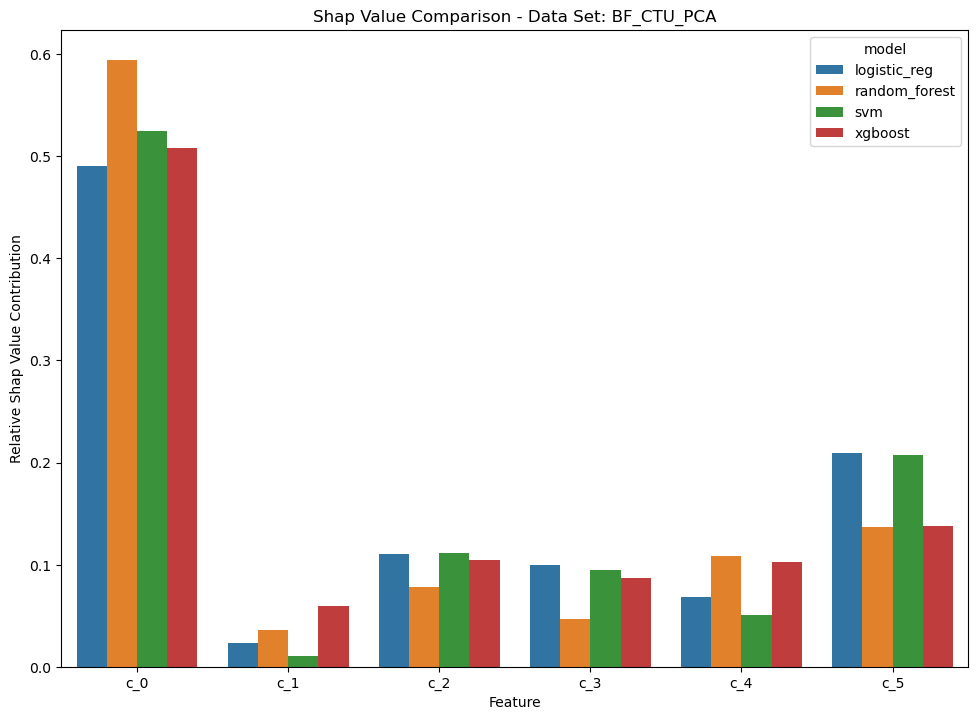

In [17]:
BF_CTU_df_pca = perform_pca(BF_CTU_df, 0.6)
compare_clfs(BF_CTU_df_pca, df_name="BF_CTU_PCA")

### Sparce-PCA

In [19]:
def perform_sparce_pca(df, ratio):
    n_components = int(np.round(ratio * (len(df.columns) - 1)))
    X = df.loc[:, df.columns != 'CONDITION']
    X_std = StandardScaler().fit_transform(X)    
    
    X_spca = pd.DataFrame(SparsePCA(n_components=n_components, random_state=42).fit_transform(feature_values_std))
    X_spca.columns = [f"c_{i}" for i in range(n_components)]
    X_spca = pd.concat([X_spca, df.CONDITION], axis = 1)
    return X_spca

In [30]:
BF_CTU_df_spca

,c_0,c_1,c_2,c_3,c_4,c_5,CONDITION
0,0.176342,0.327228,1.534813,0.304193,0.442449,0.354438,H
1,-0.514008,0.828019,-0.404491,0.656752,-0.108592,0.387022,H
2,-0.358161,0.840119,-0.300387,-0.602992,-0.014732,0.430978,H
3,1.274414,0.725576,-0.427190,-1.005719,-2.390651,0.396786,H
4,-0.120692,1.468759,-0.767799,0.319863,1.244307,0.250861,H
...,...,...,...,...,...,...,...
437,-0.077845,0.581133,-1.410370,0.872929,0.470666,-0.599373,D
438,1.129044,-1.229531,-0.431858,-0.701120,0.684549,0.409091,D
439,0.350032,0.444976,-0.485007,0.564153,1.441904,0.407892,D
440,0.840443,0.609681,-0.535091,0.595517,0.311706,0.349437,D


Cross-Validated F1-Score - Logistic Regression: 0.8144600439006368
Cross-Validated F1-Score - Random Forest: 0.829179133877936
Cross-Validated F1-Score - SVM: 0.8248975118662516
Cross-Validated F1-Score - XGBoost: 0.7988883090337802


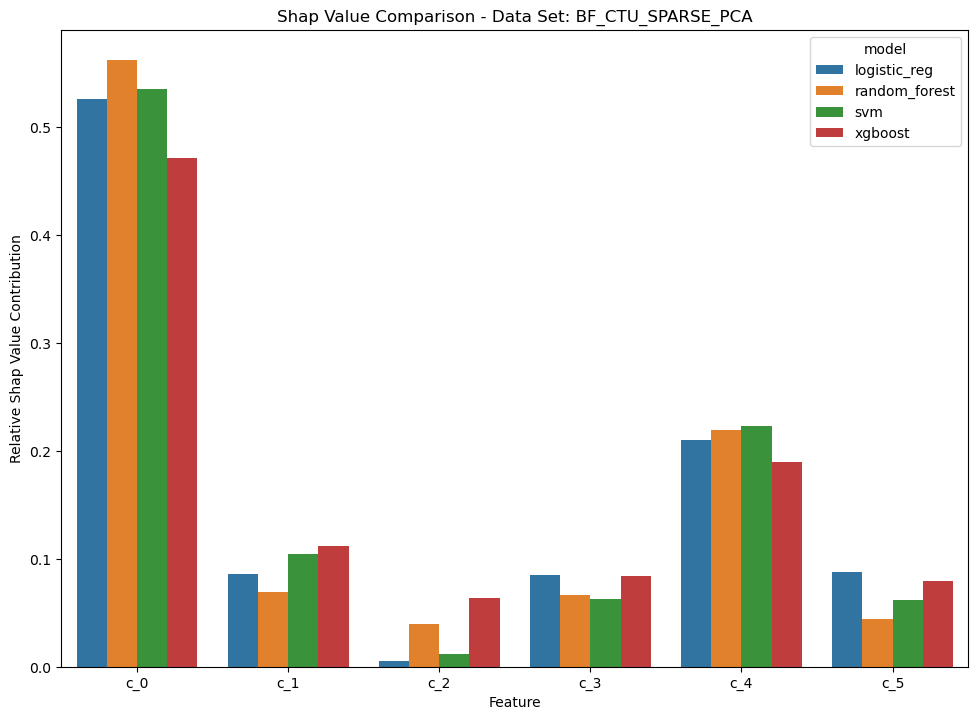

In [19]:
BF_CTU_df_spca = perform_sparce_pca(BF_CTU_df, 0.6)
compare_clfs(BF_CTU_df_spca, df_name="BF_CTU_SPARSE_PCA")

### Autoencoder

In [21]:
#Import library needed to perferm the autoencoder features extration.
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot
import tensorflow as tf


In [39]:
def run_autoencoder(df, ratio, epochs, df_name): 
    #ratio define pourcentage of features in bottleneck (latent space)
    X = df.loc[:, df.columns != 'CONDITION']
    y = df.loc[:, df.columns == 'CONDITION']
    
    #number of features at the start (input)
    n_inputs = X.shape[1]
    
    # spliting the data with StratifiedKFold
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    for train_index, test_index in kf.split(X,y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    #scaling the data
    t = MinMaxScaler()
    t.fit(X_train)
    X_train = t.transform(X_train)
    X_test = t.transform(X_test)
    
    #Difining encoder
    visible = Input(shape=(n_inputs,))
    
    e = Dense(n_inputs*2)(visible)
    e = BatchNormalization()(e)
    e = LeakyReLU()(e)

    e = Dense(n_inputs)(e)
    e = BatchNormalization()(e)
    e = LeakyReLU()(e)
    
    #Bottleneck
    n_bottleneck = round(float(n_inputs) * ratio)
    bottleneck = Dense(n_bottleneck)(e)
    
    #Difining decoder
    d = Dense(n_inputs)(bottleneck)
    d = BatchNormalization()(d)
    d = LeakyReLU()(d)

    d = Dense(n_inputs*2)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU()(d)
    
    output = Dense(n_inputs, activation='linear')(d)
    
    #defing the autoencoder model
    model = Model(inputs=visible, outputs=output)
    model.compile(optimizer='adam', loss='mse')
    
    #Ploting the model and the loss
    plot_model(model, 'autoencoder_compress.png', show_shapes=True)
    
    history = model.fit(X_train, X_train, epochs=epochs, batch_size=16, verbose=2, validation_data=(X_test,X_test))
    
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()
    pyplot.show()
    
    # define an encoder model (without the decoder)
    encoder = Model(inputs=visible, outputs=bottleneck)
    plot_model(encoder, 'encoder_compress.png', show_shapes=True)
    # save the encoder to file
    encoder.save(df_name + '_encoder.h5')
    
    return encoder

In [40]:
def perform_feature_extraction(df, ratio, epochs, df_name):
    n_components = int(np.round(ratio * (len(df.columns) - 1)))
    X = df.loc[:, df.columns != 'CONDITION']
    
    encoder = run_autoencoder(df, ratio, epochs, df_name)
    
    X_enc = pd.DataFrame(encoder.predict(X))
    X_enc.columns = [f"c_{i}" for i in range(n_components)]
    X_enc = pd.concat([X_enc, df.CONDITION], axis = 1)
    return X_enc

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Epoch 1/200
23/23 - 1s - loss: 0.8600 - val_loss: 0.4213 - 1s/epoch - 53ms/step
Epoch 2/200
23/23 - 0s - loss: 0.5183 - val_loss: 0.3742 - 78ms/epoch - 3ms/step
Epoch 3/200
23/23 - 0s - loss: 0.3523 - val_loss: 0.3159 - 83ms/epoch - 4ms/step
Epoch 4/200
23/23 - 0s - loss: 0.2428 - val_loss: 0.2615 - 85ms/epoch - 4ms/step
Epoch 5/200
23/23 - 0s - loss: 0.1725 - val_loss: 0.2147 - 87ms/epoch - 4ms/step
Epoch 6/200
23/23 - 0s - loss: 0.1261 - val_loss: 0.1732 - 104ms/epoch - 5ms/step
Epoch 7/200
23/23 - 0s - loss: 0.1021 - val_loss: 0.1462 - 84ms/epoch - 4ms/step
Epoch 8/200
23/23 - 0s - loss: 0.0838 - val_loss: 0.1239 - 90ms/epoch - 4ms/step
Epoch 9/200
23/23 - 0s - loss: 0.0789 - val_loss: 0.1004 - 92ms/epoch - 4ms/step
Epoch 10/200
23/23 - 0s - loss: 0.0677 - val_loss: 0.0902 - 77ms/epoch - 3ms/step
Epoch 11/200
23/23 - 0s - l

Epoch 99/200
23/23 - 0s - loss: 0.0365 - val_loss: 0.0289 - 78ms/epoch - 3ms/step
Epoch 100/200
23/23 - 0s - loss: 0.0344 - val_loss: 0.0285 - 124ms/epoch - 5ms/step
Epoch 101/200
23/23 - 0s - loss: 0.0353 - val_loss: 0.0283 - 77ms/epoch - 3ms/step
Epoch 102/200
23/23 - 0s - loss: 0.0347 - val_loss: 0.0289 - 81ms/epoch - 4ms/step
Epoch 103/200
23/23 - 0s - loss: 0.0363 - val_loss: 0.0291 - 79ms/epoch - 3ms/step
Epoch 104/200
23/23 - 0s - loss: 0.0367 - val_loss: 0.0290 - 68ms/epoch - 3ms/step
Epoch 105/200
23/23 - 0s - loss: 0.0378 - val_loss: 0.0290 - 80ms/epoch - 3ms/step
Epoch 106/200
23/23 - 0s - loss: 0.0354 - val_loss: 0.0292 - 70ms/epoch - 3ms/step
Epoch 107/200
23/23 - 0s - loss: 0.0349 - val_loss: 0.0290 - 66ms/epoch - 3ms/step
Epoch 108/200
23/23 - 0s - loss: 0.0349 - val_loss: 0.0288 - 66ms/epoch - 3ms/step
Epoch 109/200
23/23 - 0s - loss: 0.0353 - val_loss: 0.0284 - 71ms/epoch - 3ms/step
Epoch 110/200
23/23 - 0s - loss: 0.0348 - val_loss: 0.0287 - 71ms/epoch - 3ms/step
Epoc

Epoch 198/200
23/23 - 0s - loss: 0.0310 - val_loss: 0.0243 - 74ms/epoch - 3ms/step
Epoch 199/200
23/23 - 0s - loss: 0.0313 - val_loss: 0.0235 - 73ms/epoch - 3ms/step
Epoch 200/200
23/23 - 0s - loss: 0.0313 - val_loss: 0.0247 - 68ms/epoch - 3ms/step


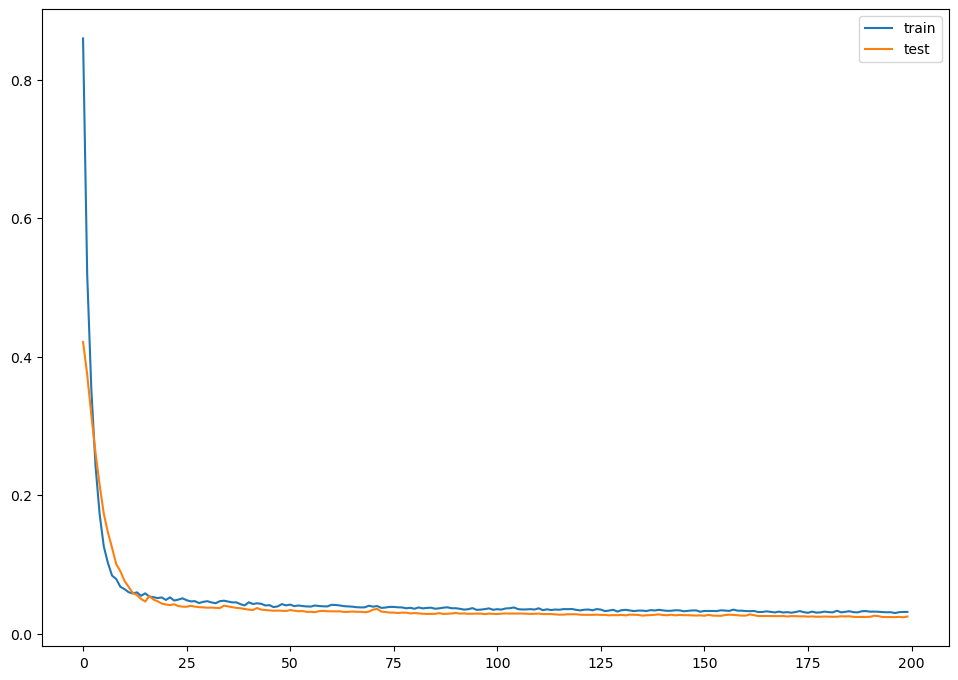

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
14/14 [==============================] - 0s 1ms/step


In [41]:
BF_CTU_df_autoencoder = perform_feature_extraction(BF_CTU_df, 0.5, epochs=200, df_name="BF_CTU_autoencoder")

In [ ]:
compare_clfs(BF_CTU_df_autoencoder, df_name="BF_CTU_autoencoder")

Cross-Validated F1-Score - Logistic Regression: 0.8155874933645693


## Experimental results for all the datasets

In this section we are going to compare the Relative Shap Value Contribution for each machine learning method and feature selection method (PCA, Sparse-PCA and Autoencoder) accross all the available datasets.

### Baseline Results

Results for all datasets without any preprocessing or feature selection technique

In [ ]:
BF_CTU_df_perf_df = compare_clfs(BF_CTU_df, df_name="BF_CTU_df", plot_name="baseline_shap_comparison_BF_CTU_df", path="plots/baseline", return_performance_df=True)
BF_OU_df_perf_df = compare_clfs(BF_OU_df, df_name="BF_OU_df", plot_name="baseline_shap_comparison_BF_OU_df", path="plots/baseline", return_performance_df=True)
BF_V_df_perf_df = compare_clfs(BF_V_df, df_name="BF_V_df", plot_name="baseline_shap_comparison_BF_V_df", path="plots/baseline", return_performance_df=True)
DT_CC_df_perf_df = compare_clfs(DT_CC_df, df_name="DT_CC_df", plot_name="baseline_shap_comparison_DT_CC_df", path="plots/baseline", return_performance_df=True)
DT_JI_df_perf_df = compare_clfs(DT_JI_df, df_name="DT_JI_df", plot_name="baseline_shap_comparison_DT_JI_df", path="plots/baseline", return_performance_df=True)
IADQ_df_perf_df = compare_clfs(IADQ_df, df_name="IADQ_df", plot_name="baseline_shap_comparison_IADQ_df", path="plots/baseline", return_performance_df=True)
IESR_df_perf_df = compare_clfs(IESR_df, df_name="IESR_df", plot_name="baseline_shap_comparison_IESR_df", path="plots/baseline", return_performance_df=True)
NAQR_df_perf_df = compare_clfs(NAQR_df, df_name="NAQR_df", plot_name="baseline_shap_comparison_NAQR_df", path="plots/baseline", return_performance_df=True)
PCL5_df_perf_df = compare_clfs(PCL5_df, df_name="PCL5_df", plot_name="baseline_shap_comparison_PCL5_df", path="plots/baseline", return_performance_df=True)
PHQ9_df_perf_df = compare_clfs(PHQ9_df, df_name="PHQ9_df", plot_name="baseline_shap_comparison_PHQ9_df", path="plots/baseline", return_performance_df=True)


Cross-Validated F1-Score - Logistic Regression: 0.9456370493683706
Cross-Validated F1-Score - Random Forest: 0.957845692753444
Cross-Validated F1-Score - SVM: 0.940907250976112
Cross-Validated F1-Score - XGBoost: 0.9609805263878395


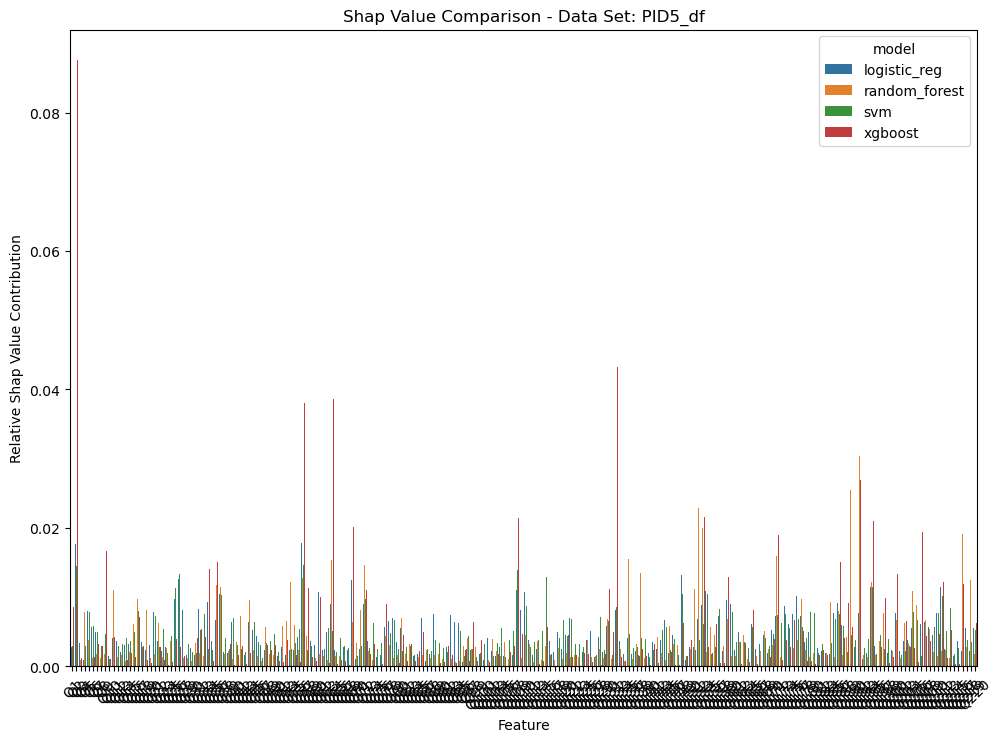

Cross-Validated F1-Score - Logistic Regression: 0.9005878344523623
Cross-Validated F1-Score - Random Forest: 0.8974124666125677
Cross-Validated F1-Score - SVM: 0.9064459830069571
Cross-Validated F1-Score - XGBoost: 0.8878975060027692


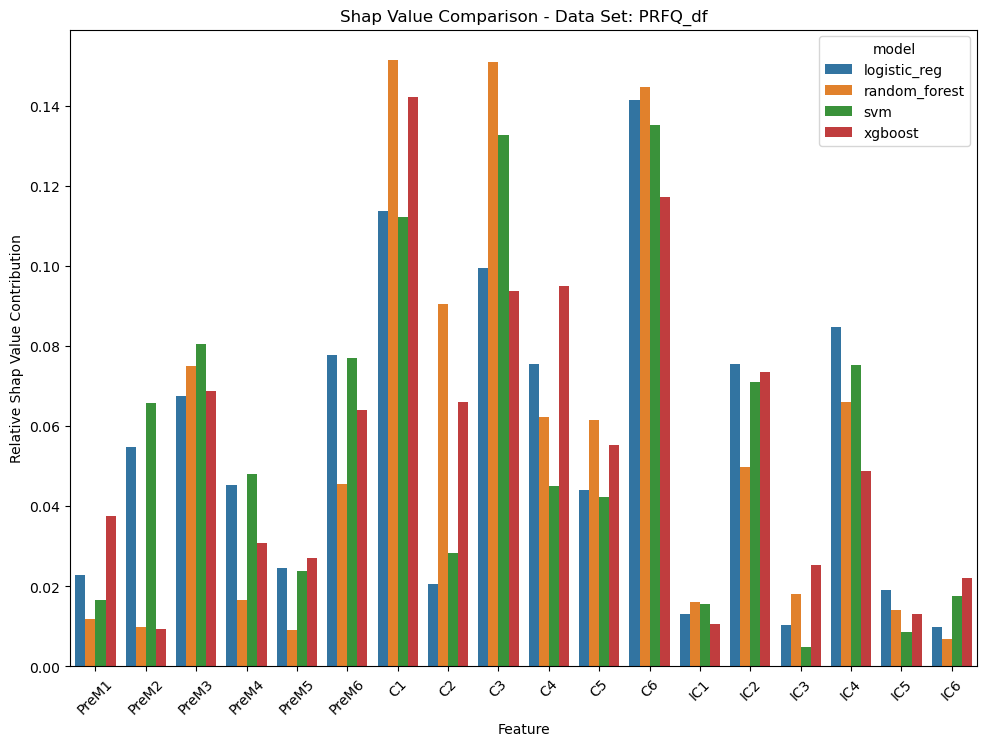

Cross-Validated F1-Score - Logistic Regression: 0.9015026712546209
Cross-Validated F1-Score - Random Forest: 0.9331101245308531
Cross-Validated F1-Score - SVM: 0.9065835288128323
Cross-Validated F1-Score - XGBoost: 0.9267540493527153


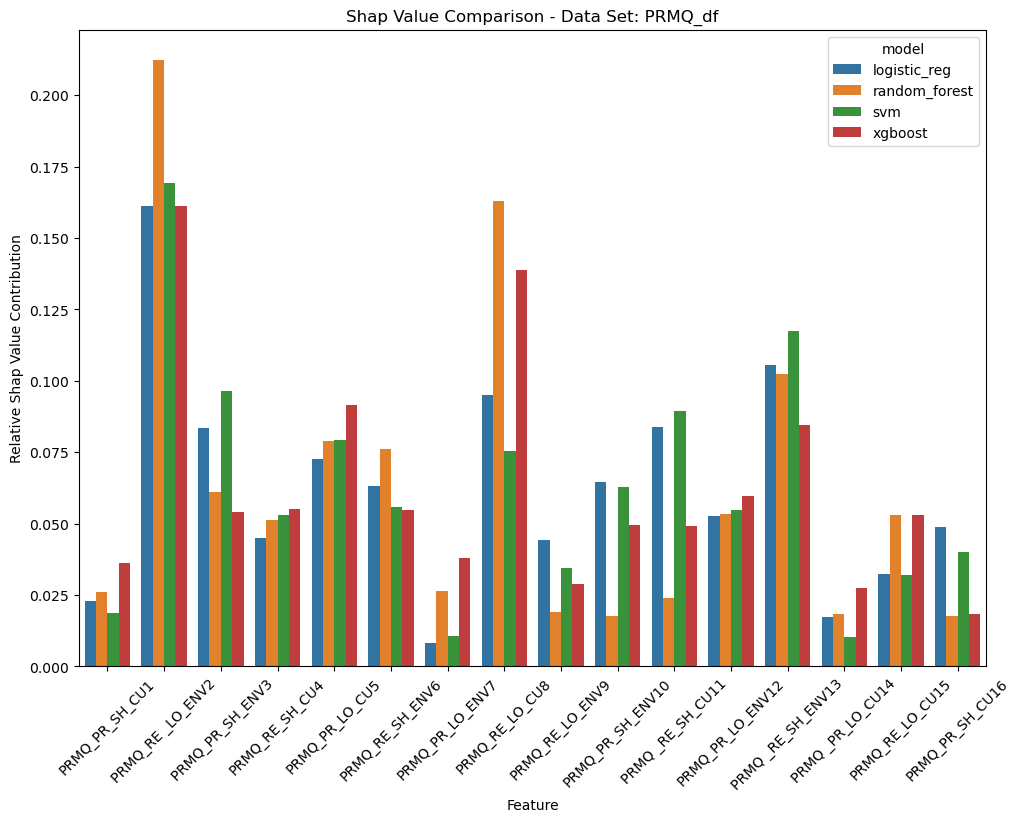

Cross-Validated F1-Score - Logistic Regression: 0.7554043670904834
Cross-Validated F1-Score - Random Forest: 0.7912966025372148
Cross-Validated F1-Score - SVM: 0.7626638997587744
Cross-Validated F1-Score - XGBoost: 0.7750717770001416


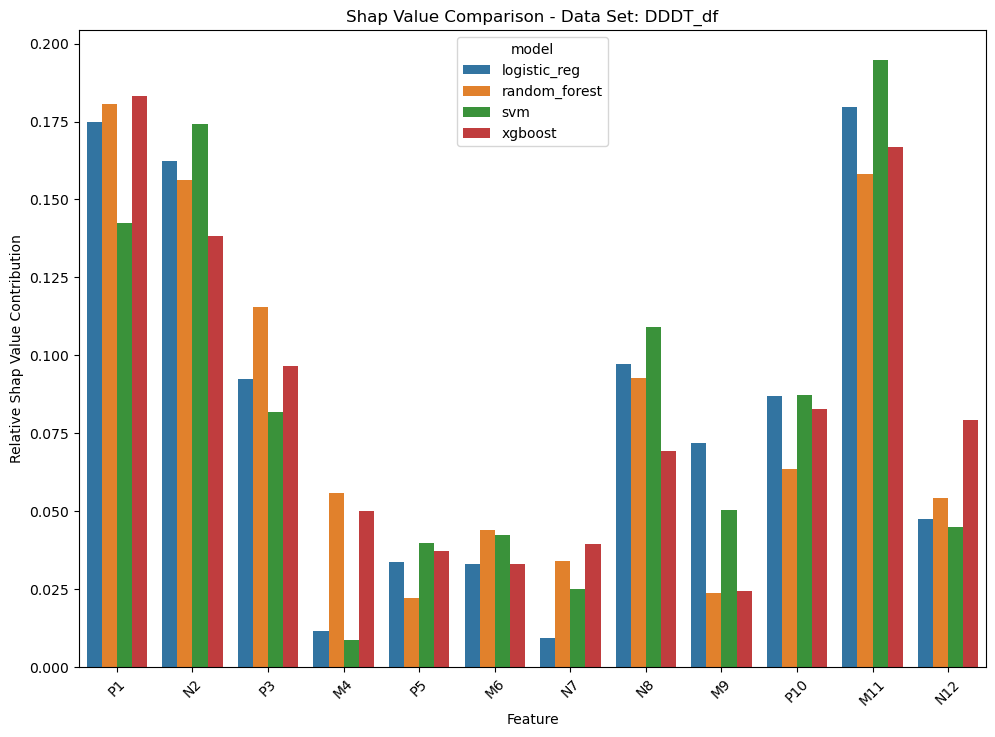

Cross-Validated F1-Score - Logistic Regression: 0.960081632835035
Cross-Validated F1-Score - Random Forest: 0.9659721752263746
Cross-Validated F1-Score - SVM: 0.9615794712807256
Cross-Validated F1-Score - XGBoost: 0.9621522385164607


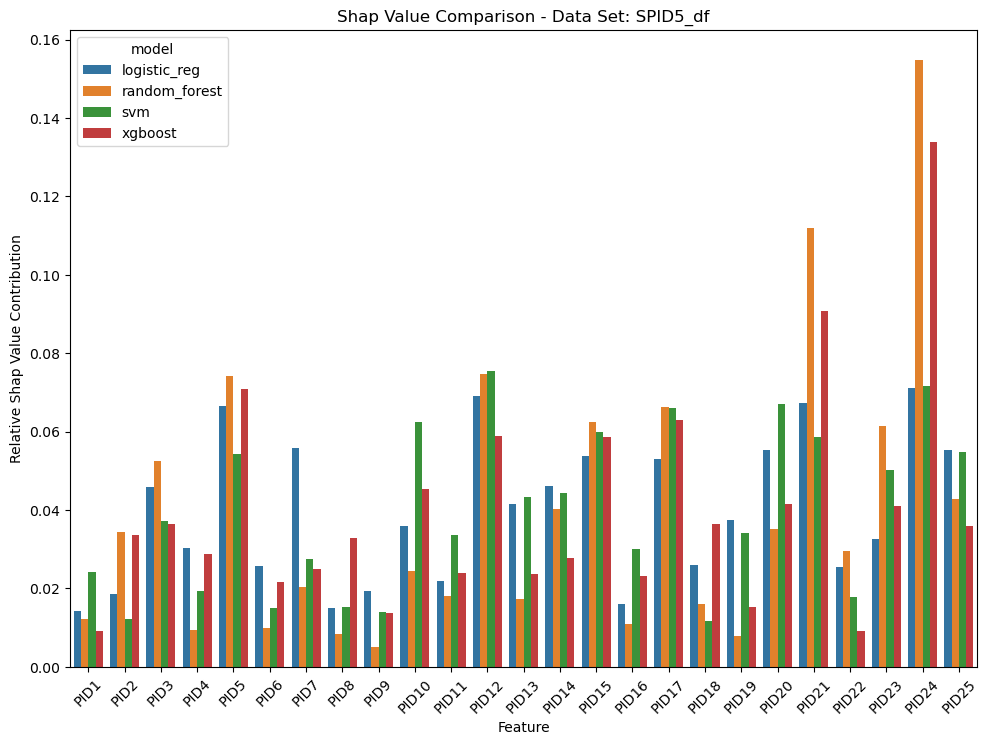

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

Cross-Validated F1-Score - Logistic Regression: 0.5829040966908303


100%|===================| 31071/31074 [44:57<00:00]        

Cross-Validated F1-Score - Random Forest: 0.6305446395156491
Cross-Validated F1-Score - SVM: 0.5697166042334455


100%|===================| 15488/15537 [00:59<00:00]        

Cross-Validated F1-Score - XGBoost: 0.6394699251603544


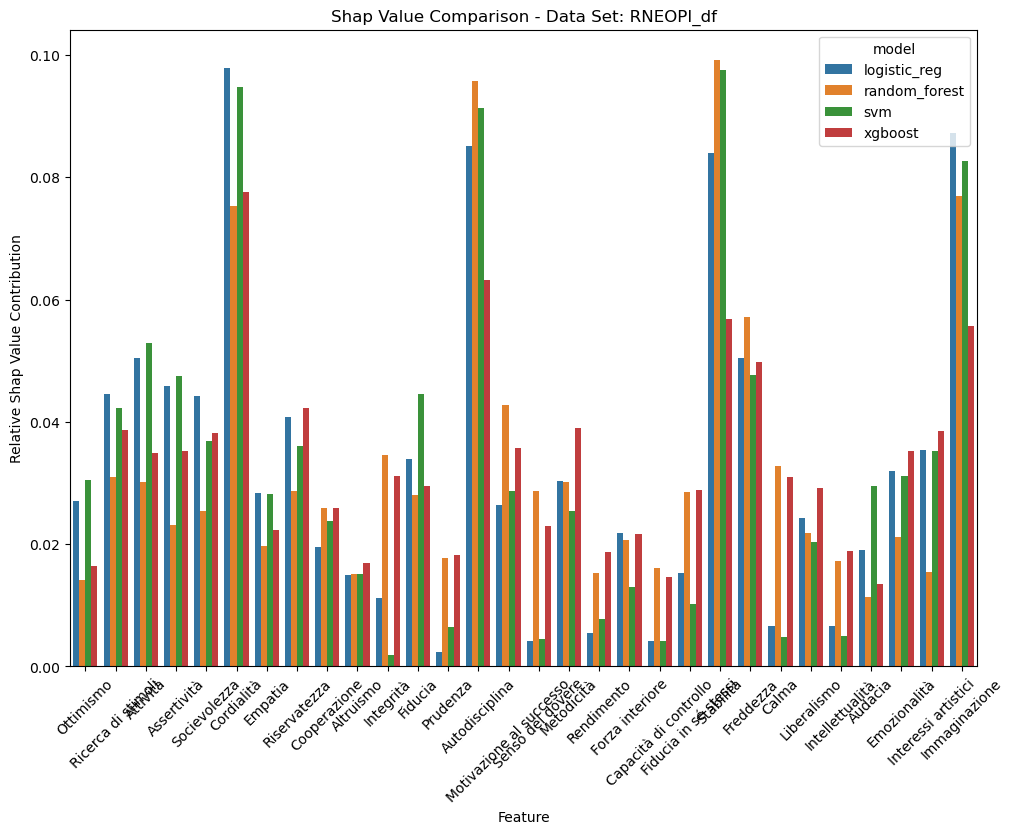

In [26]:
PID5_df_perf_df = compare_clfs(PID5_df, df_name="PID5_df", plot_name="baseline_shap_comparison_PID5_df", path="plots/baseline", return_performance_df=True)
PRFQ_df_perf_df = compare_clfs(PRFQ_df, df_name="PRFQ_df", plot_name="baseline_shap_comparison_PRFQ_df", path="plots/baseline", return_performance_df=True)
PRMQ_df_perf_df = compare_clfs(PRMQ_df, df_name="PRMQ_df", plot_name="baseline_shap_comparison_PRMQ_df", path="plots/baseline", return_performance_df=True)
DDDT_df_perf_df = compare_clfs(DDDT_df, df_name="DDDT_df", plot_name="baseline_shap_comparison_DDDT_df", path="plots/baseline", return_performance_df=True)
SPID5_df_perf_df = compare_clfs(SPID5_df, df_name="SPID5_df", plot_name="baseline_shap_comparison_SPID5_df", path="plots/baseline", return_performance_df=True)
RNEOPI_df_perf_df = compare_clfs(RNEOPI_df, df_name="RNEOPI_df", plot_name="baseline_shap_comparison_RNEOPI_df", path="plots/baseline", return_performance_df=True)

In [27]:
baseline_results_df = pd.concat([BF_CTU_df_perf_df, 
                                 BF_OU_df_perf_df, 
                                 BF_V_df_perf_df, 
                                 DT_CC_df_perf_df, 
                                 DT_JI_df_perf_df, 
                                 IADQ_df_perf_df, 
                                 IESR_df_perf_df, 
                                 NAQR_df_perf_df, 
                                 PCL5_df_perf_df, 
                                 PHQ9_df_perf_df, 
                                 PID5_df_perf_df, 
                                 PRFQ_df_perf_df, 
                                 PRMQ_df_perf_df, 
                                 DDDT_df_perf_df, 
                                 SPID5_df_perf_df, 
                                 RNEOPI_df_perf_df])
baseline_results_df.to_csv("results/results_baseline.csv", index=False)

In [30]:
baseline_results_df.head()

,Dataset,Model,F1
0,BF_CTU_df,lr,0.81
1,BF_CTU_df,rf,0.83
2,BF_CTU_df,svm,0.82
3,BF_CTU_df,xgboost,0.81
0,BF_OU_df,lr,0.83


## Feature Selection: Model agnostic methods vs Model dependent

In this section we are going to add L1 regularization to the Logistic Regression and XGboost methods and compare if it gives better results than model agnostic feature selection methods.

In [102]:
X = BF_CTU_df.loc[:, BF_CTU_df.columns != 'CONDITION'] # select all columns except CONDITION
y = np.where(BF_CTU_df["CONDITION"] == "H", 1, 0)
lambdas = np.linspace(0.001, 10, 30)
cv=5
scores = []
for c in lambdas: 
    clf = LogisticRegression(solver="liblinear", penalty="l1", C=1/c)
    output = cross_validate(clf, X, y, cv=cv, scoring='f1')
    scores.append(np.mean(output['test_score']))

In [113]:
X = BF_CTU_df.loc[:, BF_CTU_df.columns != 'CONDITION'] # select all columns except CONDITION
y = np.where(BF_CTU_df["CONDITION"] == "H", 1, 0)
lambdas = np.linspace(0.001, 20, 50)
cv=5
scores = []
for c in lambdas: 
    clf = svm.LinearSVC(penalty="l1", C=1/c, dual=False)
    output = cross_validate(clf, X, y, cv=cv, scoring='f1')
    scores.append(np.mean(output['test_score']))

Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.


In [287]:
lambdas = np.linspace(0, 20, 20)
cs = 1/(lambdas + 0.00001)

In [288]:
all_dfs = []
i = 0
for l, c in zip(lambdas, cs) :
    print(f"Lambda - l1 = {l}")
    df = compare_clfs(BF_CTU_df, 
                 df_name="BF_CTU_PCA", 
                 lr_penalty="l1", 
                 lr_C=c,
                 svm_penalty="l1",
                 svm_C=c, 
                 reg_alpha=l,
                 plot_comparison=False,
                 return_df=True
                )
    df["i"] = i
    all_dfs.append(df)
    i += 1
    
comparison = pd.concat(all_dfs, axis=0)

Lambda - l1 = 0.0
Cross-Validated F1-Score - Logistic Regression: 0.8098047607227533
Cross-Validated F1-Score - Random Forest: 0.8264135923136632
Cross-Validated F1-Score - SVM: 0.8110856959298172
Cross-Validated F1-Score - XGBoost: 0.8115609110462632
Lambda - l1 = 1.0526315789473684
Cross-Validated F1-Score - Logistic Regression: 0.8179686118479221
Cross-Validated F1-Score - Random Forest: 0.8264135923136632
Cross-Validated F1-Score - SVM: 0.808459156942129
Cross-Validated F1-Score - XGBoost: 0.818346998101924
Lambda - l1 = 2.1052631578947367
Cross-Validated F1-Score - Logistic Regression: 0.8038842566642451
Cross-Validated F1-Score - Random Forest: 0.8264135923136632
Cross-Validated F1-Score - SVM: 0.8162247247076968
Cross-Validated F1-Score - XGBoost: 0.8359858553350417
Lambda - l1 = 3.1578947368421053
Cross-Validated F1-Score - Logistic Regression: 0.8046252537491416
Cross-Validated F1-Score - Random Forest: 0.8264135923136632
Cross-Validated F1-Score - SVM: 0.81627162718962
Cross-

<IPython.core.display.Javascript object>


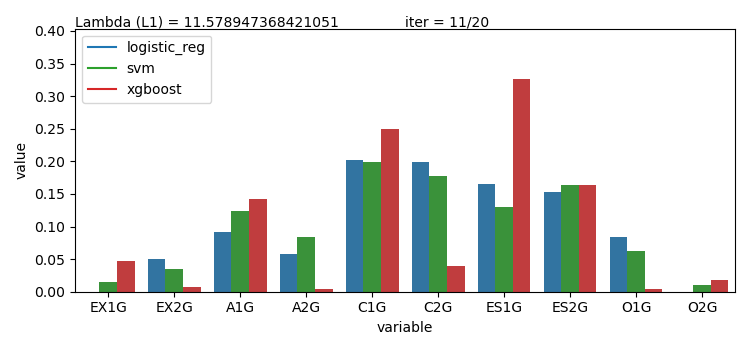

In [295]:
from matplotlib import pyplot as plt
from celluloid import Camera
from matplotlib.lines import Line2D

fig, ax = plt.subplots()
camera = Camera(fig)

labels = ['logistic_reg', 'svm', 'xgboost']
colors = ['#1f77b4', '#2ca02c', '#d62728']
handles = []
for c, l in zip(colors, labels):
    handles.append(Line2D([0], [0], color = c, label = l))

for i in range(len(lambdas)):
    data = comparison[comparison["i"] == i]
    sns.barplot(data=data, x="variable", y="value", hue="model", palette=colors)
    plt.legend(handles = handles, loc = 'upper left')
    ax.text(0, 1.01, f"Lambda (L1) = {lambdas[i]}", transform=ax.transAxes)
    ax.text(0.5, 1.01, f"iter = {i}/{len(lambdas)}", transform=ax.transAxes)
    camera.snap()
animation = camera.animate(interval = 500)
animation.save('comparison.mp4')